In [1]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from heart import *
from valve_p import *
from three_windkessel import *

In [30]:
T=1
lv=heart(tau1 = 0.17*T, tau2 = 0.4*T, m1 = 5.5,m2 = 27.5,Emax = 2.5,Emin = 0.1,Ks = 20*10**(-9),V0 = 5,T = T)
#tau1,tau2,m1,m2,Emax,Emin,Ks,V0,T
la=heart(tau1 = 0.05*T,tau2 = 0.08*T,m1 = 1,m2 = 10,Emax = 0.25,Emin = 0.15,Ks = 10*10**(-9),V0 = 4,T = T)

av=ValveinP(density = 1.06,eff_length =  0.001,Aann = 1,Kvo = 3,Kvc = 5,p_oc = 0.001)
#density, eff_length, Aann, Kvo,Kvc,p_oc
mv=ValveinP(density = 1.06, eff_length =  0.05,Aann = 0.35, Kvo = 7, Kvc = 5,p_oc = 1e-6)

cap=PressureSystem(C = 2.6, Za = 0.005, R = 0.65)#C,Za,R

In [31]:
t_end=160
t = [0,t_end]
t_span=np.arange(0,t_end,0.001)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]

In [32]:
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    p = y[6]
    #get value from class
    p_la = la.p(v_la,t,q_mv,0.94*la.T)
    p_lv = lv.p(v_lv,t,q_av)
    q1 = cap.qout(p,p_la)
    pi = cap.pi(q_av,p)
    #derivative
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    #dv_lv = 0
    dv_la = la.dv(t,v_la,q1,q_mv)
    dxi_av = av.dxi(t,xi_av,p_lv,pi)
    #dxi_av = 0
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    #dxi_mv = 0
    dq_av = av.dq(t,q_av,xi_av,p_lv,pi)
    #dq_av = 0
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)#time,q,xi,pin,pout
    dp = cap.dp(t,p,q_av,p_la)
    #dp = 0
    #derivative vector
    dy = np.array([dv_lv, dv_la, dq_av, dq_mv, dxi_av, dxi_mv, dp])
    return dy

#initial condition
y_initial = np.array([350, 20, 10, 10, 0.9, 0.1, 10])

#integration
sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method= 'LSODA')

## post-pocess

In [33]:
aeff_av = []
et_lv = []
B_av = []
p_lv_values = []
p_la_values = []
pi = []
dp_av = []
L_av = []
dq_mv = []
dxi_mv = []
L_mv = []
B_mv = []
aeff_mv = []
dp_mv = []
dxi_av = []
et_la = []
dp_r1=[]
q1 = []
dp = []
for i,j in zip(sol.t,range(len(sol.y[4]))):
    aeff_av.append(av.Aeff(i, sol.y[4][j]))
    et_lv.append(lv.Et(i))
    et_la.append(la.Et(i,0.94*T))
    B_av.append(av.B(i, sol.y[4][j]))
    L_av.append(av.L(i, sol.y[4][j]))
    p_lv_values.append(lv.p(sol.y[0][j], i, sol.y[2][j]))
    p_la_values.append(la.p(sol.y[1][j], i, sol.y[3][j], 0.94*la.T))
    pi.append(cap.pi(sol.y[2][j],sol.y[6][j]))
    dp_av.append(p_lv_values[-1]-pi[-1])
    dq_mv.append(mv.dq(i,sol.y[3][j],sol.y[5][j],p_la_values[-1],p_lv_values[-1]))#time,q,xi,pin,pout
    dxi_mv.append(mv.dxi(i,sol.y[5][j],p_la_values[-1],p_lv_values[-1]))
    L_mv.append(mv.L(i, sol.y[5][j]))
    B_mv.append(mv.L(i, sol.y[5][j]))
    aeff_mv.append(mv.Aeff(i, sol.y[5][j]))
    dp_mv.append(p_la_values[-1]-p_lv_values[-1])
    dxi_av.append(av.dxi(i,sol.y[4][j],p_lv_values[j], cap.pi(sol.y[2][j], sol.y[6][j])))
    dp_r1.append(sol.y[6][j]-pi[-1])
    q1.append(cap.qout(sol.y[6][j],p_la_values[-1]))
    dp.append( cap.dp(i,sol.y[6][j],sol.y[2][j],p_la_values[-1]) )

## Cellml model

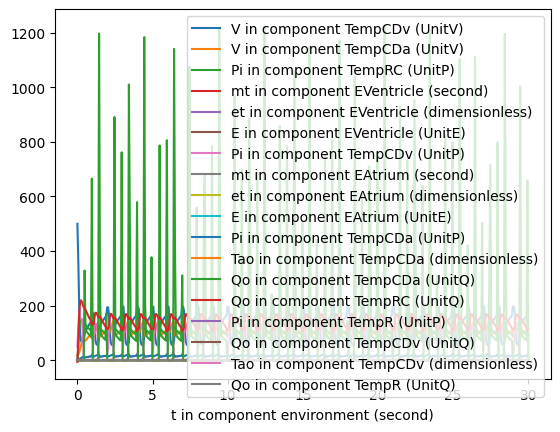

In [17]:
# Size of variable arrays:
sizeAlgebraic = 15
sizeStates = 3
sizeConstants = 21
from math import *
from numpy import *

def createLegends():
    legend_states = [""] * sizeStates
    legend_rates = [""] * sizeStates
    legend_algebraic = [""] * sizeAlgebraic
    legend_voi = ""
    legend_constants = [""] * sizeConstants
    legend_voi = "t in component environment (second)"
    legend_algebraic[7] = "Pi in component TempCDa (UnitP)"
    legend_algebraic[11] = "Pi in component TempR (UnitP)"
    legend_algebraic[10] = "Qo in component TempRC (UnitQ)"
    legend_algebraic[12] = "Qo in component TempCDv (UnitQ)"
    legend_algebraic[3] = "Pi in component TempCDv (UnitP)"
    legend_algebraic[9] = "Qo in component TempCDa (UnitQ)"
    legend_constants[0] = "CVao in component ParaLeftHeart (UnitCV)"
    legend_algebraic[2] = "E in component EVentricle (UnitE)"
    legend_states[0] = "V in component TempCDv (UnitV)"
    legend_constants[1] = "PlvIni in component ParaLeftHeart (UnitP)"
    legend_constants[2] = "VlvIni in component ParaLeftHeart (UnitV)"
    legend_algebraic[13] = "Tao in component TempCDv (dimensionless)"
    legend_constants[3] = "Vlv0 in component ParaLeftHeart (UnitV)"
    legend_constants[4] = "CVmi in component ParaLeftHeart (UnitCV)"
    legend_algebraic[6] = "E in component EAtrium (UnitE)"
    legend_states[1] = "V in component TempCDa (UnitV)"
    legend_constants[5] = "PlaIni in component ParaLeftHeart (UnitP)"
    legend_constants[6] = "VlaIni in component ParaLeftHeart (UnitV)"
    legend_algebraic[8] = "Tao in component TempCDa (dimensionless)"
    legend_constants[7] = "Vla0 in component ParaLeftHeart (UnitV)"
    legend_constants[8] = "ElvMax in component ParaLeftHeart (UnitE)"
    legend_constants[9] = "ElvMin in component ParaLeftHeart (UnitE)"
    legend_constants[10] = "T in component ParaLeftHeart (second)"
    legend_constants[11] = "Ts1 in component ParaLeftHeart (dimensionless)"
    legend_constants[12] = "Ts2 in component ParaLeftHeart (dimensionless)"
    legend_algebraic[0] = "mt in component EVentricle (second)"
    legend_algebraic[1] = "et in component EVentricle (dimensionless)"
    legend_constants[13] = "ElaMax in component ParaLeftHeart (UnitE)"
    legend_constants[14] = "ElaMin in component ParaLeftHeart (UnitE)"
    legend_constants[15] = "Tpwb in component ParaLeftHeart (dimensionless)"
    legend_constants[16] = "Tpww in component ParaLeftHeart (dimensionless)"
    legend_algebraic[4] = "mt in component EAtrium (second)"
    legend_algebraic[5] = "et in component EAtrium (dimensionless)"
    legend_states[2] = "Pi in component TempRC (UnitP)"
    legend_algebraic[14] = "Qo in component TempR (UnitQ)"
    legend_constants[17] = "Rc in component ParaWestkessel (UnitR)"
    legend_constants[18] = "Rv in component ParaWestkessel (UnitR)"
    legend_constants[19] = "Cv in component ParaWestkessel (UnitC)"
    legend_constants[20] = "P0v in component ParaWestkessel (UnitP)"
    legend_rates[0] = "d/dt V in component TempCDv (UnitV)"
    legend_rates[1] = "d/dt V in component TempCDa (UnitV)"
    legend_rates[2] = "d/dt Pi in component TempRC (UnitP)"
    return (legend_states, legend_algebraic, legend_voi, legend_constants)

def initConsts():
    constants = [0.0] * sizeConstants; states = [0.0] * sizeStates;
    constants[0] = 350.
    constants[1] = 1.0
    constants[2] = 5.0
    constants[3] = 500
    constants[4] = 400.
    constants[5] = 1.0
    constants[6] = 4.0
    constants[7] = 20
    constants[8] = 2.5
    constants[9] = 0.1
    constants[10] = 1.0
    constants[11] = 0.3
    constants[12] = 0.45
    constants[13] = 0.25
    constants[14] = 0.15
    constants[15] = 0.92
    constants[16] = 0.09
    constants[17] = 0.005
    constants[18] = 0.65
    constants[19] = 2.6
    constants[20] = 0.
    states[0] = constants[3]
    states[1] = constants[7]
    states[2] = constants[20]
    return (states, constants)

def computeRates(voi, states, constants):
    rates = [0.0] * sizeStates; algebraic = [0.0] * sizeAlgebraic
    algebraic[4] = voi-constants[10]*floor(voi/constants[10])
    algebraic[5] = custom_piecewise([greater_equal(algebraic[4] , 0.00000) & less_equal(algebraic[4] , ((constants[15]+constants[16])-1.00000)*constants[10]), 1.00000-cos((2.00000*3.14159*(algebraic[4]-(constants[15]-1.00000)*constants[10]))/(constants[16]*constants[10])) , greater(algebraic[4] , ((constants[15]+constants[16])-1.00000)*constants[10]) & less_equal(algebraic[4] , constants[15]*constants[10]), 0.00000 , greater(algebraic[4] , constants[15]*constants[10]) & less_equal(algebraic[4] , constants[10]), 1.00000-cos((2.00000*3.14159*(algebraic[4]-constants[15]*constants[10]))/(constants[16]*constants[10])) , True, float('nan')])
    algebraic[6] = constants[14]+(algebraic[5]*(constants[13]-constants[14]))/2.00000
    algebraic[7] = constants[5]+algebraic[6]*(states[1]-constants[6])
    algebraic[10] = (states[2]-algebraic[7])/constants[18]
    algebraic[0] = voi-constants[10]*floor(voi/constants[10])
    algebraic[1] = custom_piecewise([greater_equal(algebraic[0] , 0.00000) & less_equal(algebraic[0] , constants[11]*constants[10]), 1.00000-cos((3.14159*algebraic[0])/(constants[11]*constants[10])) , greater(algebraic[0] , constants[11]*constants[10]) & less_equal(algebraic[0] , constants[12]*constants[10]), 1.00000+cos((3.14159*(algebraic[0]-constants[11]*constants[10]))/((constants[12]-constants[11])*constants[10])) , greater(algebraic[0] , constants[12]*constants[10]) & less(algebraic[0] , constants[10]), 0.00000 , True, float('nan')])
    algebraic[2] = constants[9]+(algebraic[1]*(constants[8]-constants[9]))/2.00000
    algebraic[3] = constants[1]+algebraic[2]*(states[0]-constants[2])
    algebraic[8] = custom_piecewise([greater_equal(algebraic[7] , algebraic[3]), 1.00000 , less(algebraic[7] , algebraic[3]), 0.00000 , True, float('nan')])
    algebraic[9] = custom_piecewise([greater_equal(algebraic[7] , algebraic[3]), constants[4]*algebraic[8]*(power(fabs(algebraic[7]-algebraic[3]), 0.500000)) , less(algebraic[7] , algebraic[3]), -1.00000*constants[4]*algebraic[8]*(power(fabs(algebraic[3]-algebraic[7]), 0.500000)) , True, float('nan')])
    rates[1] = algebraic[10]-algebraic[9]
    rootfind_0(voi, constants, rates, states, algebraic)
    rates[0] = algebraic[9]-algebraic[12]
    algebraic[14] = algebraic[12]
    rates[2] = (algebraic[14]-algebraic[10])/constants[19]
    return(rates)

def computeAlgebraic(constants, states, voi):
    algebraic = array([[0.0] * len(voi)] * sizeAlgebraic)
    states = array(states)
    voi = array(voi)
    algebraic[4] = voi-constants[10]*floor(voi/constants[10])
    algebraic[5] = custom_piecewise([greater_equal(algebraic[4] , 0.00000) & less_equal(algebraic[4] , ((constants[15]+constants[16])-1.00000)*constants[10]), 1.00000-cos((2.00000*3.14159*(algebraic[4]-(constants[15]-1.00000)*constants[10]))/(constants[16]*constants[10])) , greater(algebraic[4] , ((constants[15]+constants[16])-1.00000)*constants[10]) & less_equal(algebraic[4] , constants[15]*constants[10]), 0.00000 , greater(algebraic[4] , constants[15]*constants[10]) & less_equal(algebraic[4] , constants[10]), 1.00000-cos((2.00000*3.14159*(algebraic[4]-constants[15]*constants[10]))/(constants[16]*constants[10])) , True, float('nan')])
    algebraic[6] = constants[14]+(algebraic[5]*(constants[13]-constants[14]))/2.00000
    algebraic[7] = constants[5]+algebraic[6]*(states[1]-constants[6])
    algebraic[10] = (states[2]-algebraic[7])/constants[18]
    algebraic[0] = voi-constants[10]*floor(voi/constants[10])
    algebraic[1] = custom_piecewise([greater_equal(algebraic[0] , 0.00000) & less_equal(algebraic[0] , constants[11]*constants[10]), 1.00000-cos((3.14159*algebraic[0])/(constants[11]*constants[10])) , greater(algebraic[0] , constants[11]*constants[10]) & less_equal(algebraic[0] , constants[12]*constants[10]), 1.00000+cos((3.14159*(algebraic[0]-constants[11]*constants[10]))/((constants[12]-constants[11])*constants[10])) , greater(algebraic[0] , constants[12]*constants[10]) & less(algebraic[0] , constants[10]), 0.00000 , True, float('nan')])
    algebraic[2] = constants[9]+(algebraic[1]*(constants[8]-constants[9]))/2.00000
    algebraic[3] = constants[1]+algebraic[2]*(states[0]-constants[2])
    algebraic[8] = custom_piecewise([greater_equal(algebraic[7] , algebraic[3]), 1.00000 , less(algebraic[7] , algebraic[3]), 0.00000 , True, float('nan')])
    algebraic[9] = custom_piecewise([greater_equal(algebraic[7] , algebraic[3]), constants[4]*algebraic[8]*(power(fabs(algebraic[7]-algebraic[3]), 0.500000)) , less(algebraic[7] , algebraic[3]), -1.00000*constants[4]*algebraic[8]*(power(fabs(algebraic[3]-algebraic[7]), 0.500000)) , True, float('nan')])
    algebraic[14] = algebraic[12]
    return algebraic

initialGuess0 = None
def rootfind_0(voi, constants, rates, states, algebraic):
    """Calculate values of algebraic variables for DAE"""
    from scipy.optimize import fsolve
    global initialGuess0
    if initialGuess0 is None: initialGuess0 = ones(3)*0.1
    if not iterable(voi):
        soln = fsolve(residualSN_0, initialGuess0, args=(algebraic, voi, constants, rates, states), xtol=1E-6)
        initialGuess0 = soln
        algebraic[11] = soln[0]
        algebraic[12] = soln[1]
        algebraic[13] = soln[2]
    else:
        for (i,t) in enumerate(voi):
            soln = fsolve(residualSN_0, initialGuess0, args=(algebraic[:,i], voi[i], constants, rates[:i], states[:,i]), xtol=1E-6)
            initialGuess0 = soln
            algebraic[11][i] = soln[0]
            algebraic[12][i] = soln[1]
            algebraic[13][i] = soln[2]

def residualSN_0(algebraicCandidate, algebraic, voi, constants, rates, states):
    resid = array([0.0] * 3)
    algebraic[11] = algebraicCandidate[0]
    algebraic[12] = algebraicCandidate[1]
    algebraic[13] = algebraicCandidate[2]
    resid[0] = (algebraic[13]-(custom_piecewise([greater_equal(algebraic[3] , algebraic[11]), 1.00000 , less(algebraic[3] , algebraic[11]), 0.00000 , True, float('nan')])))
    resid[1] = (algebraic[12]-(custom_piecewise([greater_equal(algebraic[3] , algebraic[11]), constants[0]*algebraic[13]*(power(fabs(algebraic[3]-algebraic[11]), 0.500000)) , less(algebraic[3] , algebraic[11]), -1.00000*constants[0]*algebraic[13]*(power(fabs(algebraic[11]-algebraic[3]), 0.500000)) , True, float('nan')])))
    resid[2] = (algebraic[11]-(states[2]+constants[17]*algebraic[12]))
    return resid

def custom_piecewise(cases):
    """Compute result of a piecewise function"""
    return select(cases[0::2],cases[1::2])

def solve_model():
    """Solve model with ODE solver"""
    from scipy.integrate import ode
    # Initialise constants and state variables
    (init_states, constants) = initConsts()

    # Set timespan to solve over
    voi = linspace(0, 30, 500)

    # Construct ODE object to solve
    r = ode(computeRates)
    r.set_integrator('vode', method='bdf', atol=1e-06, rtol=1e-06, max_step=1)
    r.set_initial_value(init_states, voi[0])
    r.set_f_params(constants)

    # Solve model
    states = array([[0.0] * len(voi)] * sizeStates)
    states[:,0] = init_states
    for (i,t) in enumerate(voi[1:]):
        if r.successful():
            r.integrate(t)
            states[:,i+1] = r.y
        else:
            break

    # Compute algebraic variables
    algebraic = computeAlgebraic(constants, states, voi)
    return (voi, states, algebraic)

def plot_model(voi, states, algebraic):
    """Plot variables against variable of integration"""
    import pylab
    (legend_states, legend_algebraic, legend_voi, legend_constants) = createLegends()
    pylab.figure(1)
    pylab.plot(voi,vstack((states,algebraic)).T)
    pylab.xlabel(legend_voi)
    pylab.legend(legend_states + legend_algebraic, loc='best')
    pylab.show()

if __name__ == "__main__":
    (voi, states, algebraic) = solve_model()
    plot_model(voi, states, algebraic)

## compare with cellml

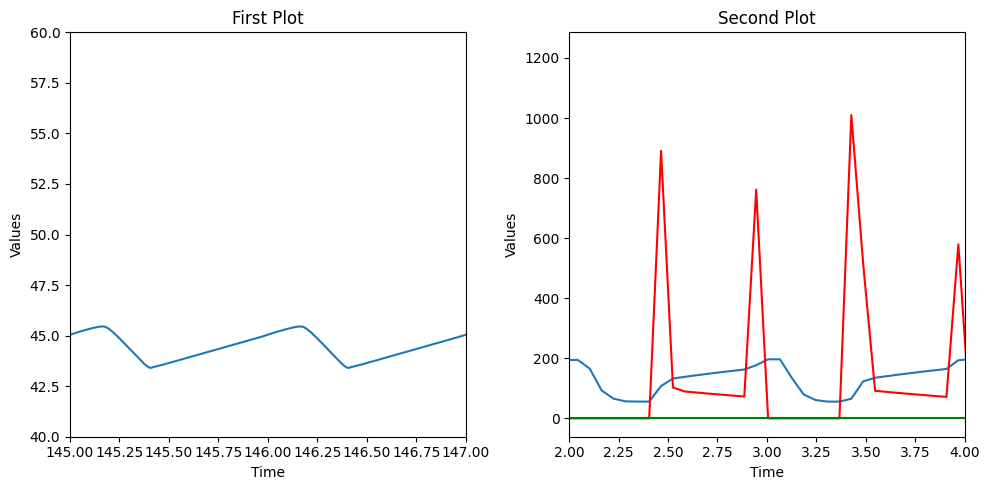

In [35]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # figsize can be adjusted based on your display needs

# Plotting on the own subplot
axs[0].plot(sol.t, sol.y[0])#vlv
axs[0].plot(sol.t, sol.y[2], 'g')#qav
axs[0].plot(sol.t, sol.y[3], 'r')#qmv
axs[0].set_xlim(145,147)
axs[0].set_ylim(40, 60)
axs[0].set_title('First Plot')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

# Plotting on the cellml subplot
axs[1].plot(voi, states[0])  # v_lv
axs[1].plot(voi, algebraic[9], 'r')  # q_mv
axs[1].plot(voi, algebraic[12], 'g')  # q_av
axs[1].set_xlim(2,4)
#axs[1].set_ylim(50,200)
axs[1].set_title('Second Plot')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')

# Display the figure with subplots
plt.tight_layout() 
plt.show()


## the results after setting constant when some parameters = cellml 21

In [19]:
print('cell_ml_q1=',algebraic[10][21])
print('pla=',algebraic[7][21])
print('plv=',algebraic[3][21])
print('p=',states[2][22])
print('vla=',states[1][21])
print('vlv=',states[0][22])
print('qmv=',algebraic[9][21])
print('qav=',algebraic[12][21])
print('tao_av=',algebraic[13][21])
print('==========================')
print('vla=', sol.y[1][0])
print('vlv=', sol.y[0][0])
print('q1=', q1[1])
print('pla=',p_la_values[0])
print('plv=',p_lv_values[0])
print('qmv=',sol.y[3][0])
print('qav=',sol.y[2][0])
print('p=',sol.y[6][600])
print('dp=',dp[0])
print('pi=',pi[2])
print('xi_mv',sol.y[5][1])
print('xi_av',sol.y[4][1])
print('dxi_av',dxi_av[0])
print('B_av=', B_av[0])
print('L_av=', L_av[0])

cell_ml_q1= 174.13277572623758
pla= 18.229615264234198
plv= 132.16864557198582
p= 128.55652998908107
vla= 118.86410176156132
vlv= 56.60035226986859
qmv= -0.0
qav= 0.0
tao_av= 0.0
vla= 20.0
vlv= 350.0
q1= 10.334644399642377
pla= 3.272727272727273
plv= 34.5
qmv= 9.999999999999998
qav= 10.0
p= 11.006317093510942
dp= -0.13448090371167104


TypeError: 'float' object is not subscriptable

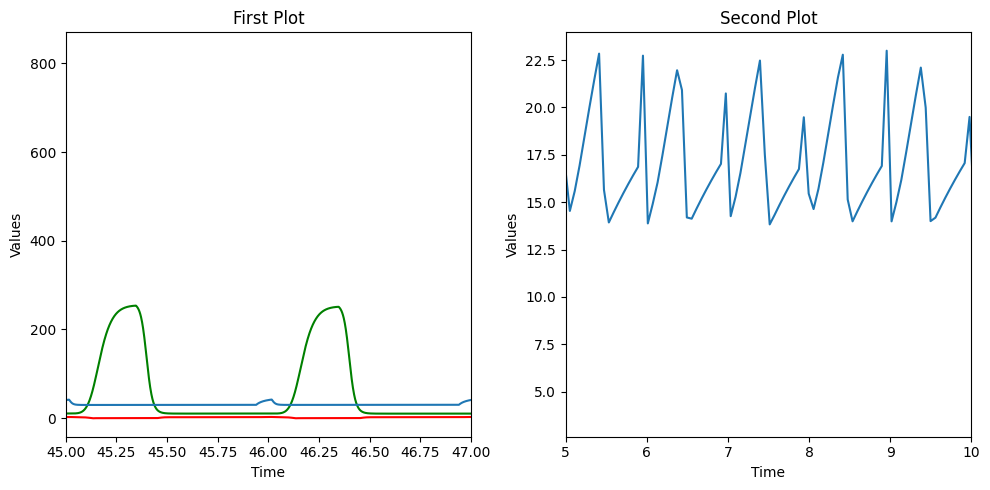

In [20]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # figsize can be adjusted based on your display needs

# Plotting on the first subplot
axs[0].plot(sol.t, p_lv_values,'g')
axs[0].plot(sol.t, p_la_values)
axs[0].plot(sol.t, sol.y[3], 'r')#mv
axs[0].set_xlim(45,47)
#axs[0].set_ylim(-5, 100)
axs[0].set_title('First Plot')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

# Plotting on the second subplot
axs[1].plot(voi, algebraic[7])  # p_la
#axs[1].plot(voi, algebraic[9], 'r')  # q_mv
#axs[1].plot(voi, algebraic[3],'g')  # p_lv
axs[1].set_xlim(5,10)
#axs[1].set_ylim(0, 20)  # Uncomment if y-limits are needed
axs[1].set_title('Second Plot')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')

# Display the figure with subplots
plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()

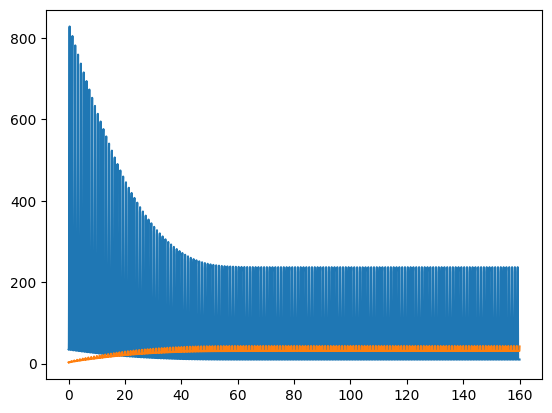

In [21]:
plt.plot(sol.t, p_lv_values)
plt.plot(sol.t, p_la_values)
plt.show()

In [22]:
print(states[0][21])

59.454507574087934


In [23]:
for i in range(len(voi)):
    if algebraic[2][i]>2.4 and algebraic[2][i]<2.41:
        print(i)
algebraic[2][21]

21
155


2.4087747996531723

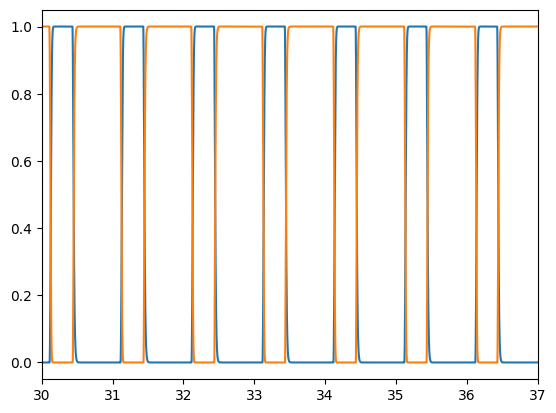

In [36]:
plt.plot(sol.t, sol.y[4])
plt.plot(sol.t, sol.y[5])
#plt.plot(voi,algebraic[13],'r')
plt.plot(voi,algebraic[8],'y')
plt.xlim(30,37)
plt.show()

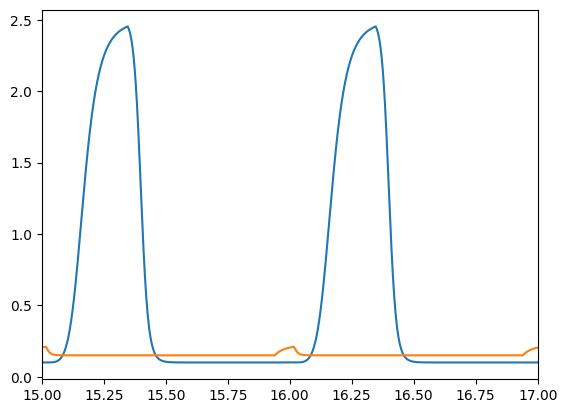

In [29]:
plt.plot(sol.t, et_lv)
plt.plot(sol.t, et_la)
#plt.plot(voi, algebraic[6])
#plt.plot(voi, algebraic[2])
plt.xlim(15,17)
plt.show()

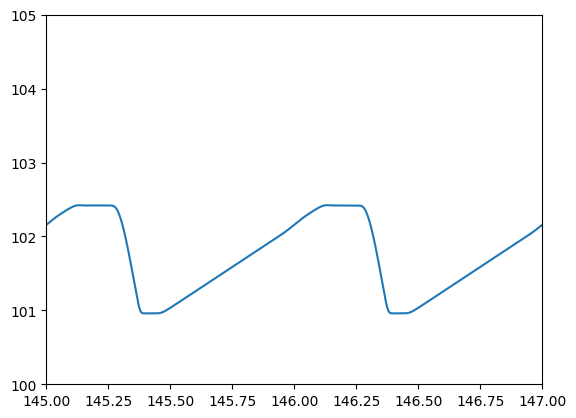

In [27]:
plt.plot(sol.t, sol.y[0])
plt.plot(sol.t, sol.y[1], 'r')
plt.xlim(145,147)
plt.ylim(100, 105)
plt.show()

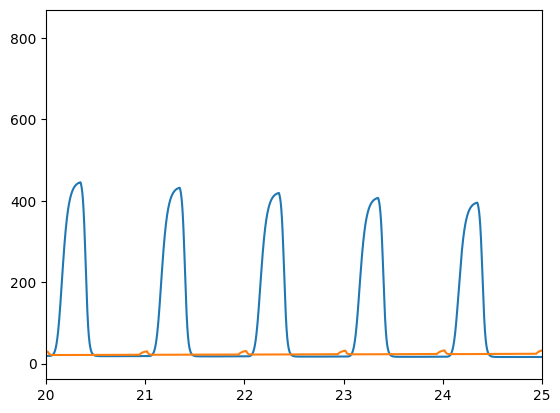

In [28]:
plt.plot(sol.t, p_lv_values)
#plt.plot(voi, algebraic[3])
#plt.plot(voi, algebraic[7])
plt.plot(sol.t, p_la_values)
plt.xlim(20,25)
#plt.ylim(0,50)
plt.show()